In [1]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv('with_variables_v2.csv')
time = pd.read_csv('applications data.csv')

In [233]:
final_cols = [
    'address_count_30',
 'fulladdress_count_30',
 'fulladdress_count_3',
 'address_count_3',
 'fulladdress_count_1',
 'ssn_name_dob_count_30',
 'fulladdress_homephone_day_since',
 'fulladdress_homephone_count_14',
 'name_dob_day_since',
 'ssn_name_dob_day_since',
 'name_dob_count_14',
 'ssn_name_day_since',
 'ssn_dob_count_14',
 'ssn_count_14',
 'ssn_firstname_count_14',
 'ssn_lastname_count_14',
 'ssn_name_count_14',
 'address_count_1_by_14',
 'fulladdress_count_1_by_14',
 'name_count_14',
 'name_day_since',
 'fulladdress_count_1_by_30',
 'fulladdress_count_1_by_7',
 'ssn_name_count_1_by_30',
 'dob_count_30'
]

In [234]:
final = df[final_cols].copy()
final['label'] = time.fraud_label
final.index = df.record
final

,address_count_30,fulladdress_count_30,fulladdress_count_3,address_count_3,fulladdress_count_1,ssn_name_dob_count_30,fulladdress_homephone_day_since,fulladdress_homephone_count_14,name_dob_day_since,ssn_name_dob_day_since,...,ssn_name_count_14,address_count_1_by_14,fulladdress_count_1_by_14,name_count_14,name_day_since,fulladdress_count_1_by_30,fulladdress_count_1_by_7,ssn_name_count_1_by_30,dob_count_30,label
record,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,0.0,1,0.0,0.0,...,1,14.0,14.0,1,0.0,30.0,7.0,30.0,1,0
2,1,1,1,1,1,1,0.0,1,0.0,0.0,...,1,14.0,14.0,1,0.0,30.0,7.0,30.0,1,1
3,1,1,1,1,1,1,0.0,1,0.0,0.0,...,1,14.0,14.0,1,0.0,30.0,7.0,30.0,1,0
4,1,1,1,1,1,1,0.0,1,0.0,0.0,...,1,14.0,14.0,1,0.0,30.0,7.0,30.0,1,0
5,1,1,1,1,1,1,0.0,1,0.0,0.0,...,1,14.0,14.0,1,0.0,30.0,7.0,30.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999996,1,1,1,1,1,1,365.0,1,365.0,365.0,...,1,14.0,14.0,1,30.0,30.0,7.0,30.0,2,0
999997,1,1,1,1,1,1,365.0,1,365.0,365.0,...,1,14.0,14.0,1,365.0,30.0,7.0,30.0,2,0
999998,1,1,1,1,1,1,365.0,1,365.0,365.0,...,1,14.0,14.0,1,304.0,30.0,7.0,30.0,110,0


In [235]:
train_test = final.loc[:833507,:]
oot = final.loc[833508:,:]

In [210]:
from sklearn.model_selection import train_test_split

In [305]:
X = train_test.drop('label', axis = 1)
y = train_test.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [306]:
train = X_train.copy()
train['label'] = y_train
test = X_test.copy()
test['label'] = y_test

In [307]:
from sklearn.utils import resample

In [308]:
good = train[train.label == 0]
bad = train[train.label == 1]

len(bad)/len(train)

0.014494715950186305

In [309]:
## Upsampling the data since our dataset is imbalanced (percentage of class fraud aka class bad is only about 1.4%)
## here I'm trying to make the proportion of bad to be about 35%.

bad_upsampled = resample(bad, 
                         replace=True,    
                         n_samples = int(len(good)/1.8),   
                         random_state=100)

train_upsampled = pd.concat([good, bad_upsampled])

In [310]:
len(bad_upsampled)/len(train_upsampled)

0.3571422981332433

In [311]:
def FDR3(data):
    result = data.copy()
    result['prediction'] = predictions[:,1]
    result = result.sort_values('prediction', ascending=False)
    topRows = int(round(len(result)*0.03))
    return round(result.head(topRows).label.sum()/result.label.sum(),4)

In [312]:
train_predictors_upsampled = train_upsampled.drop('label', axis = 1).values
label = train_upsampled.label.values

train_predictors = train.drop('label', axis = 1).values
test_predictors = test.drop('label', axis = 1).values
oot_predictors = oot.drop('label', axis = 1).values

## Baseline Logistics

In [194]:
from sklearn.linear_model import LogisticRegression

In [258]:
model = LogisticRegression(solver = 'lbfgs')
model.fit(train_predictors_upsampled, label)

/Users/aslanshi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [162]:
predictions = model.predict_proba(train_predictors)
FDR3(train)

0.5083

In [163]:
predictions = model.predict_proba(test_predictors)
FDR3(test)

0.5166

In [164]:
predictions = model.predict_proba(oot_predictors)
FDR3(oot)

0.4891

## Single Tree

In [199]:
from sklearn.tree import DecisionTreeClassifier

In [259]:
dtree = DecisionTreeClassifier(min_samples_split=300, min_samples_leaf=60)
dtree.fit(train_predictors_upsampled, label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=60, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [233]:
predictions = dtree.predict_proba(train_predictors)
FDR3(train)

0.5762

In [234]:
predictions = dtree.predict_proba(test_predictors)
FDR3(test)

0.5082

In [235]:
predictions = dtree.predict_proba(oot_predictors)
FDR3(oot)

0.5101

## Random Forest

In [261]:
from sklearn.ensemble import RandomForestClassifier

In [262]:
trees = RandomForestClassifier(max_depth=20, n_estimators=100, max_features=10)
trees.fit(train_predictors_upsampled, label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [263]:
predictions = trees.predict_proba(train_predictors)
FDR3(train)

0.5955

In [264]:
predictions = trees.predict_proba(test_predictors)
FDR3(test)

0.5037

In [265]:
predictions = trees.predict_proba(oot_predictors)
FDR3(oot)

0.4371

## Boosted Trees

#### Adaboost

In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [61]:
adatrees = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=800, learning_rate=0.002)
adatrees.fit(train_predictors_upsampled, label)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [62]:
predictions = adatrees.predict_proba(train_predictors)
FDR3(train)

0.5189

In [63]:
predictions = adatrees.predict_proba(test_predictors)
FDR3(test)

0.5196

In [64]:
predictions = adatrees.predict_proba(oot_predictors)
FDR3(oot)

0.4958

#### Gradient Boost

In [270]:
from sklearn.ensemble import GradientBoostingClassifier

In [271]:
clf = GradientBoostingClassifier(n_estimators=800, learning_rate=0.005, max_depth=5)
clf.fit(train_predictors_upsampled, label)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [272]:
predictions = clf.predict_proba(train_predictors)
FDR3(train)

0.5354

In [273]:
predictions = clf.predict_proba(test_predictors)
FDR3(test)

0.5189

In [274]:
predictions = clf.predict_proba(oot_predictors)
FDR3(oot)

0.5172

## SVM

In [37]:
from sklearn.svm import SVC

In [1]:
svc = SVC(probability=True)
svc.fit(train_predictors_upsampled, label)

In [2]:
predictions = svc.predict_proba(train_predictors)
FDR3(train)

In [73]:
predictions = svc.predict_proba(test_predictors)
FDR3(test)

0.5196

In [74]:
predictions = svc.predict_proba(oot_predictors)
FDR3(oot)

0.4958

## KNN

In [318]:
from sklearn.neighbors import KNeighborsClassifier

In [319]:
knn = KNeighborsClassifier(n_neighbors=100).
knn.fit(train_predictors_upsampled, label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [324]:
predictions = knn.predict_proba(train_predictors)
FDR3(train)

0.5509

In [325]:
predictions = knn.predict_proba(test_predictors)
FDR3(test)

0.5006

In [326]:
predictions = knn.predict_proba(oot_predictors)
FDR3(oot)

0.4891

## Nerual Networks

In [18]:
from sklearn.neural_network import MLPClassifier

In [334]:
nn = MLPClassifier(hidden_layer_sizes=(6,))
nn.fit(train_predictors_upsampled, label)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(6,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [314]:
predictions = nn.predict_proba(train_predictors)
FDR3(train)

0.5304

In [315]:
predictions = nn.predict_proba(test_predictors)
FDR3(test)

0.5197

In [316]:
predictions = nn.predict_proba(oot_predictors)
FDR3(oot)

0.5176

## ROC

In [178]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [335]:
fpr_nn, tpr_nn, _ = roc_curve(oot.label.values, nn.predict_proba(oot_predictors)[:,1])
fpr_lr, tpr_lr, _ = roc_curve(oot.label.values, model.predict_proba(oot_predictors)[:,1])
fpr_dt, tpr_dt, _ = roc_curve(oot.label.values, dtree.predict_proba(oot_predictors)[:,1])
fpr_ts, tpr_ts, _ = roc_curve(oot.label.values, trees.predict_proba(oot_predictors)[:,1])
fpr_bt, tpr_bt, _ = roc_curve(oot.label.values, clf.predict_proba(oot_predictors)[:,1])
fpr_knn, tpr_knn, _ = roc_curve(oot.label.values, knn.predict_proba(oot_predictors)[:,1])

In [336]:
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_ts = auc(fpr_ts, tpr_ts)
roc_auc_bt = auc(fpr_bt, tpr_bt)
roc_auc_knn = auc(fpr_knn, tpr_knn)

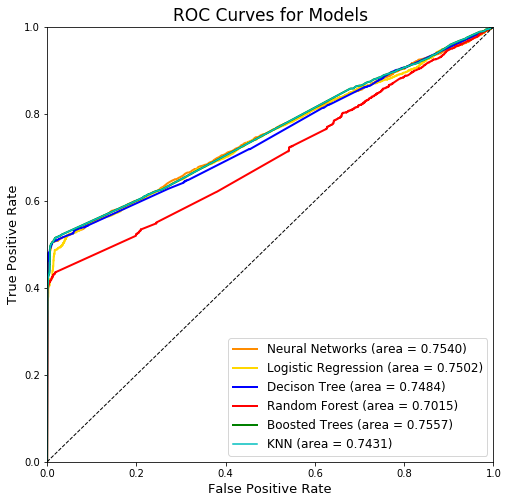

In [354]:
## random split 20

fig = plt.figure(figsize=(8,8))
plt.plot(fpr_nn, tpr_nn, color = 'darkorange', lw = 2, label = 'Neural Networks (area = {0:.4f})'.format(roc_auc_nn))
plt.plot(fpr_lr, tpr_lr, color = 'gold', lw = 2, label = 'Logistic Regression (area = {0:.4f})'.format(roc_auc_lr))
plt.plot(fpr_dt, tpr_dt, color = 'b', lw = 2, label = 'Decison Tree (area = {0:.4f})'.format(roc_auc_dt))
plt.plot(fpr_ts, tpr_ts, color = 'r', lw = 2, label = 'Random Forest (area = {0:.4f})'.format(roc_auc_ts))
plt.plot(fpr_bt, tpr_bt, color = 'g', lw = 2, label = 'Boosted Trees (area = {0:.4f})'.format(roc_auc_bt))
plt.plot(fpr_bt, tpr_bt, color = 'c', lw = 1.5, label = 'KNN (area = {0:.4f})'.format(roc_auc_knn))
plt.plot([0,1], [0,1], color = 'black', lw = 1, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title('ROC Curves for Models', fontsize = 17)
plt.legend(loc = 'lower right', fontsize = 12)

In [353]:
# fig.savefig('roc_smaller.png')